In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings

warnings.filterwarnings("ignore")

In [3]:
labels_df = pd.read_csv('dataset\metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [4]:
os.listdir('dataset\Brain Tumor Data Set')


['Brain Tumor', 'Healthy']

In [5]:
labels_df.shape

(4600, 6)

In [13]:
data_dir = "dataset\Brain Tumor Data Set"
data_dir = pathlib.Path(data_dir)
print(data_dir)

dataset\Brain Tumor Data Set


In [14]:
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


Copying files: 4600 files [00:05, 904.10 files/s]


In [15]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [17]:
data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

In [18]:
train_set = torchvision.datasets.ImageFolder(
    data_dir.joinpath("train"), transform=transform
)
train_set.transform
val_set = torchvision.datasets.ImageFolder(
    data_dir.joinpath("val"), transform=transform
)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [19]:
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 

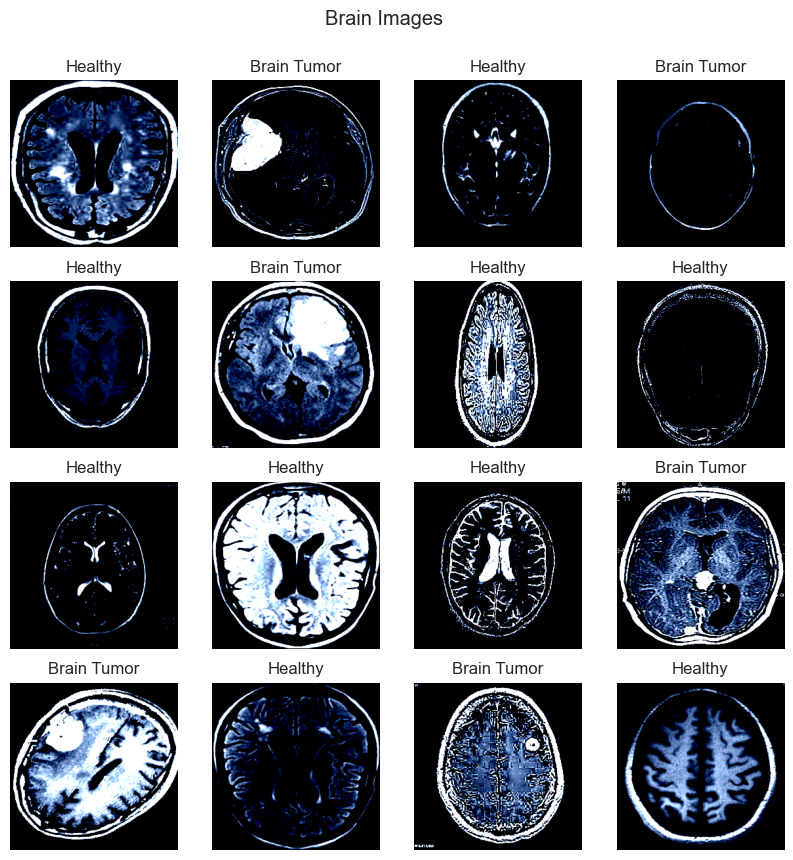

In [20]:
# Visualiztion some images from Train Set

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4

for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose(1, 2, 0)
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle("Brain Images", y=0.95)

plt.show()

In [21]:
# Preparing a DataLoader

batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, num_workers=2
)

In [22]:
for key, val in {"Training data": train_loader, "Validation data": val_loader}.items():
    for X, y in val:
        print(f"{key}")
        print(f" Shape of X is {X.shape}")
        print(f" Shape of y is {y.shape}")
        break

Training data
 Shape of X is torch.Size([64, 3, 256, 256])
 Shape of y is torch.Size([64])
Validation data
 Shape of X is torch.Size([64, 3, 256, 256])
 Shape of y is torch.Size([64])


In [23]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [24]:
class CNN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_TUMOR, self).__init__()

        cin, hin, win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(cin, init_f, kernel_size=3)
        h, w = findConv2dOutShape(hin, win, self.conv1)

        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)

        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv3)

        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)

        self.num_flatten = 8 * init_f * h * w
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [25]:
params_model = {
    "shape_in": (3, 256, 256),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2,
}

cnn_model = CNN_TUMOR(params_model)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [27]:
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

In [28]:
loss_func = nn.NLLLoss(reduction="sum")

In [29]:
opt = torch.optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [31]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group["lr"]


def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)

    pred = output.argmax(dim=1, keepdim=True)

    metric_b = pred.eq(target.view_as(pred)).sum().item()  # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


def loss_epoch(model, loss_func, dataset_dl, opt=None):

    run_loss = 0.0
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:

        xb = xb.to(device)
        yb = yb.to(device)

        output = model(xb)  # get model output

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        run_loss = loss_b

        if metric_b is not None:
            t_metric += metric_b

    loss = run_loss / float(len_data)  # average loss value
    metric = t_metric / float(len_data)  # average metric value

    return loss, metric

In [34]:
def Train_Val(model, params, verbose=False):

    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]

    # history of loss values in each epoch
    loss_history = {"train": [], "val": []}
    # histroy of metric values in each epoch
    metric_history = {"train": [], "val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss = float("inf")

    for epoch in tqdm(range(epochs)):

        current_lr = get_lr(opt)
        if verbose:
            print("Epoch {}/{}, current lr={}".format(epoch, epochs - 1, current_lr))

        model.train()

        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        torch.save(model.state_dict(), weight_path)
        if verbose:
            print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if verbose:
            print(
                f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}"
            )
            print("-" * 10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [35]:
params_train = {
    "train": train_loader,
    "val": val_loader,
    "epochs": 60,
    "optimiser": optim.Adam(cnn_model.parameters(), lr=3e-4),
    "lr_change": ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, verbose=0),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "weight_path",
}

cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

<Axes: >

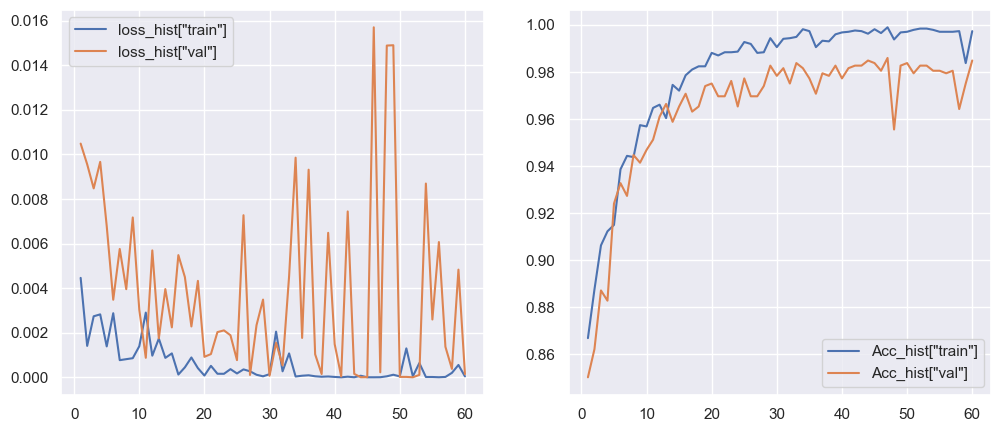

In [36]:
# Convergence History Plot
epochs = params_train["epochs"]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(
    x=[*range(1, epochs + 1)],
    y=loss_hist["train"],
    ax=ax[0],
    label='loss_hist["train"]',
)

sns.lineplot(
    x=[*range(1, epochs + 1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]'
)

sns.lineplot(
    x=[*range(1, epochs + 1)],
    y=metric_hist["train"],
    ax=ax[1],
    label='Acc_hist["train"]',
)

sns.lineplot(
    x=[*range(1, epochs + 1)], y=metric_hist["val"], ax=ax[1], label='Acc_hist["val"]'
)

In [37]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       503
         1.0       0.98      0.98      0.98       418

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




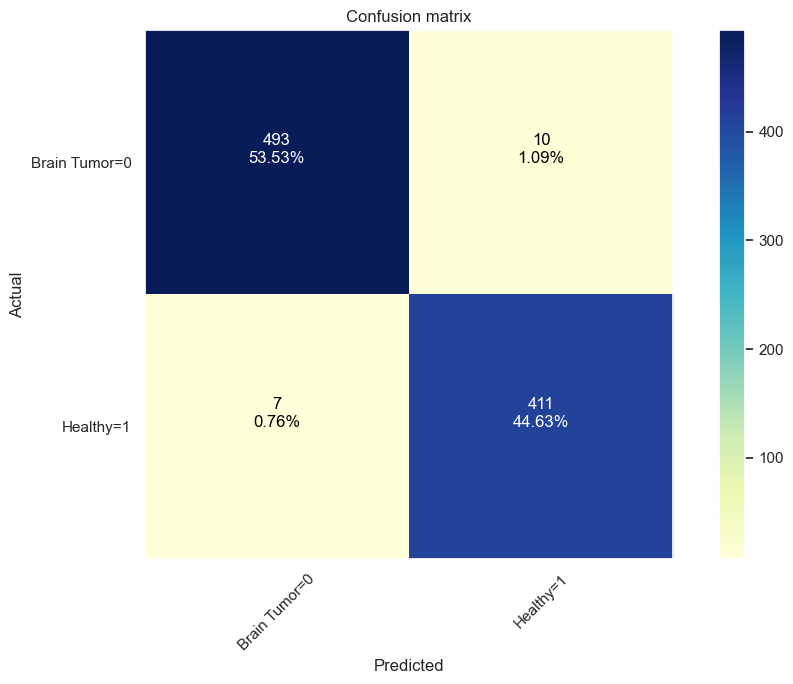

In [38]:
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [39]:
torch.save(cnn_model, "Brain_Tumor_model.pt")